# becquerel fitting example

In [1]:
import warnings

import lmfit
import matplotlib.pyplot as plt
import numpy as np

import becquerel as bq

%matplotlib inline
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2

np.random.seed(0)

warnings.filterwarnings("ignore")

Read an example spectrum into a Spectrum object

In [2]:
spec1 = bq.Spectrum.from_file("../tests/samples/digibase_5min_30_1.spe")

SpeFile: Reading file ../tests/samples/digibase_5min_30_1.spe


Plot the entire spectrum and the ROI we want to fit

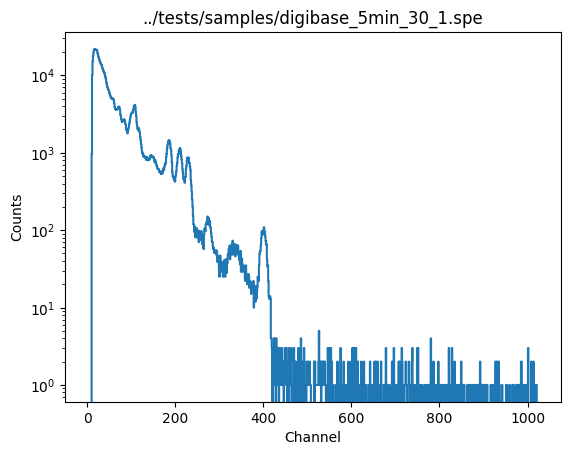

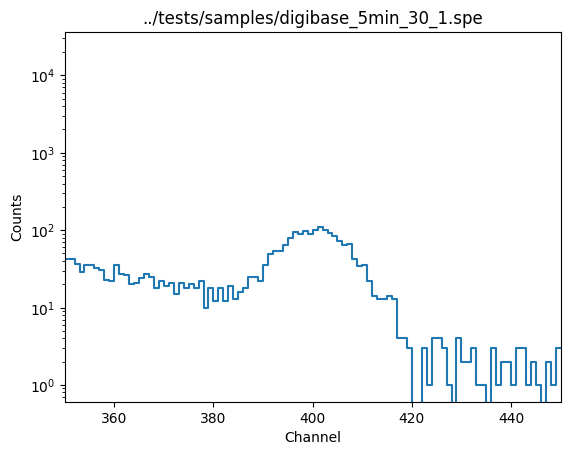

In [3]:
spec1.plot(yscale="log")
plt.show()

spec1.plot(yscale="log", xlim=(350, 450))
plt.show()

Let's first try a Gaussian peak shape and a simple linear background

In [4]:
model = bq.fitting.GaussModel(prefix="gauss0_") + bq.fitting.LineModel(prefix="linear_")

Pass our model and data to a Fitter object, then perform the fit

In [5]:
fitter = bq.Fitter(
    model,
    x=spec1.bin_indices,
    y=spec1.counts_vals,
    y_unc=spec1.counts_uncs,
    roi=(350, 450),
)

fitter.fit()

`custom_plot()` lets us see the fit result and diagnostics simultaneously

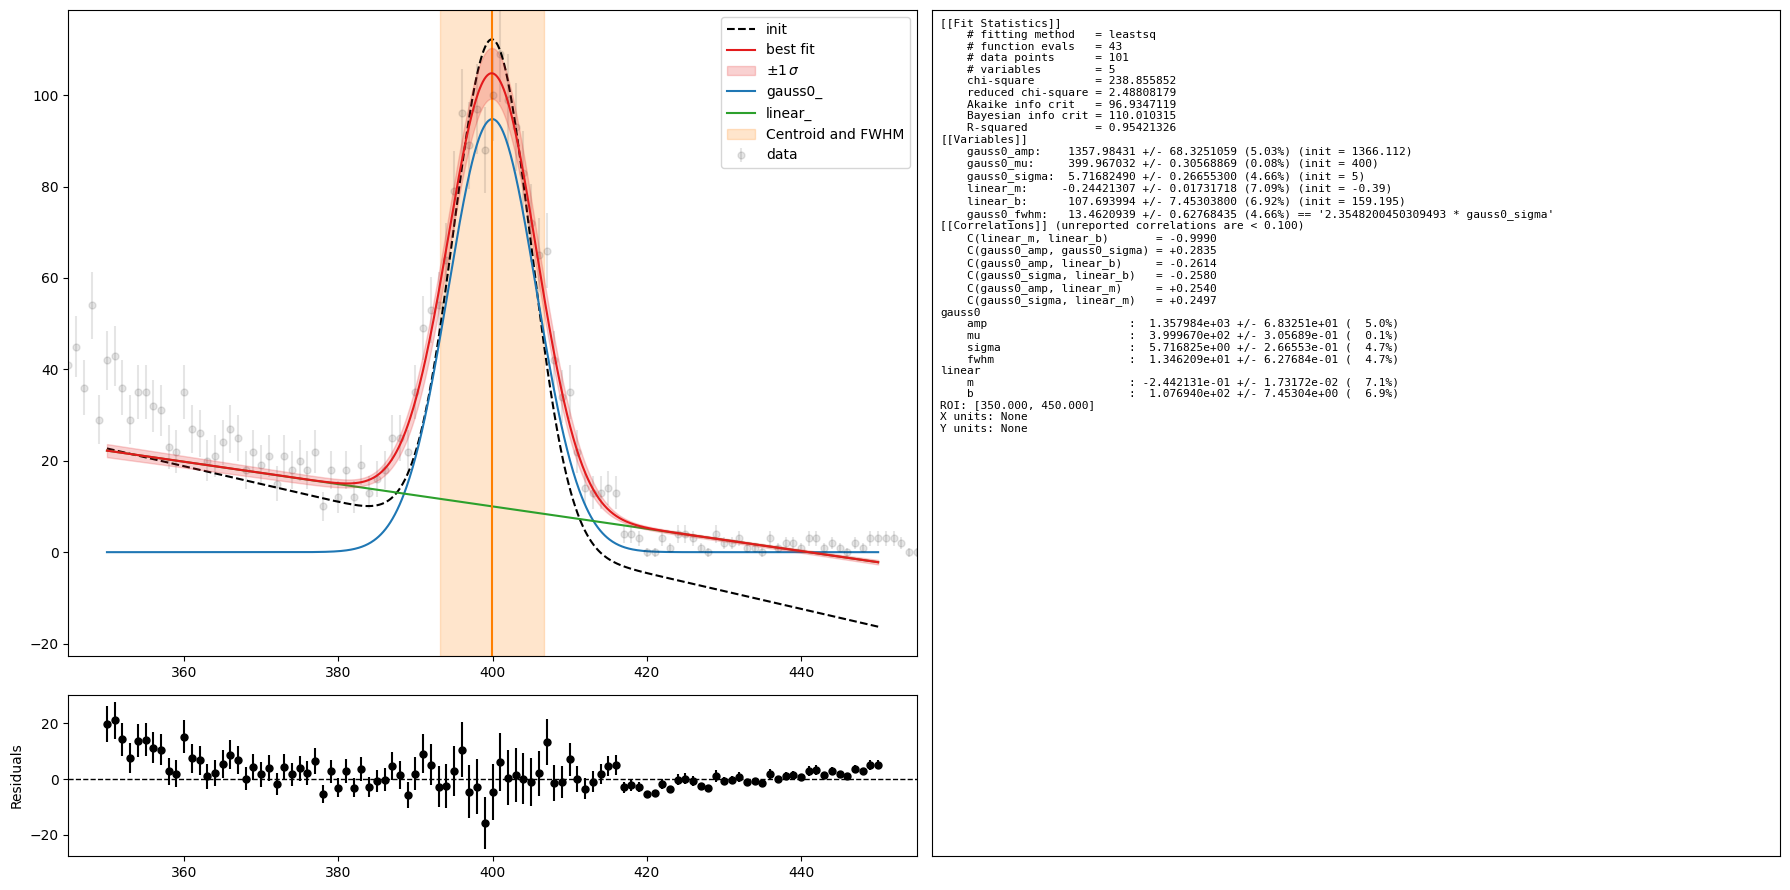

In [6]:
fitter.custom_plot()
plt.tight_layout()
plt.show()

It looks like there's still a trend in the residuals. Let's try an exponential background model instead of linear.
Note we can pass a list of string model names to the Fitter.

In [7]:
fitter = bq.Fitter(
    ["gauss", "exp"],
    x=spec1.bin_indices,
    y=spec1.counts_vals,
    y_unc=spec1.counts_uncs,
    roi=(350, 450),
)
fitter.fit(backend="lmfit")

We can also specify that we want to plot residuals relative to the bin error (`residual_type=sigma`) or relative to the model (`residual_type=rel`) instead of absolute residuals (`residual_type=abs`, default).

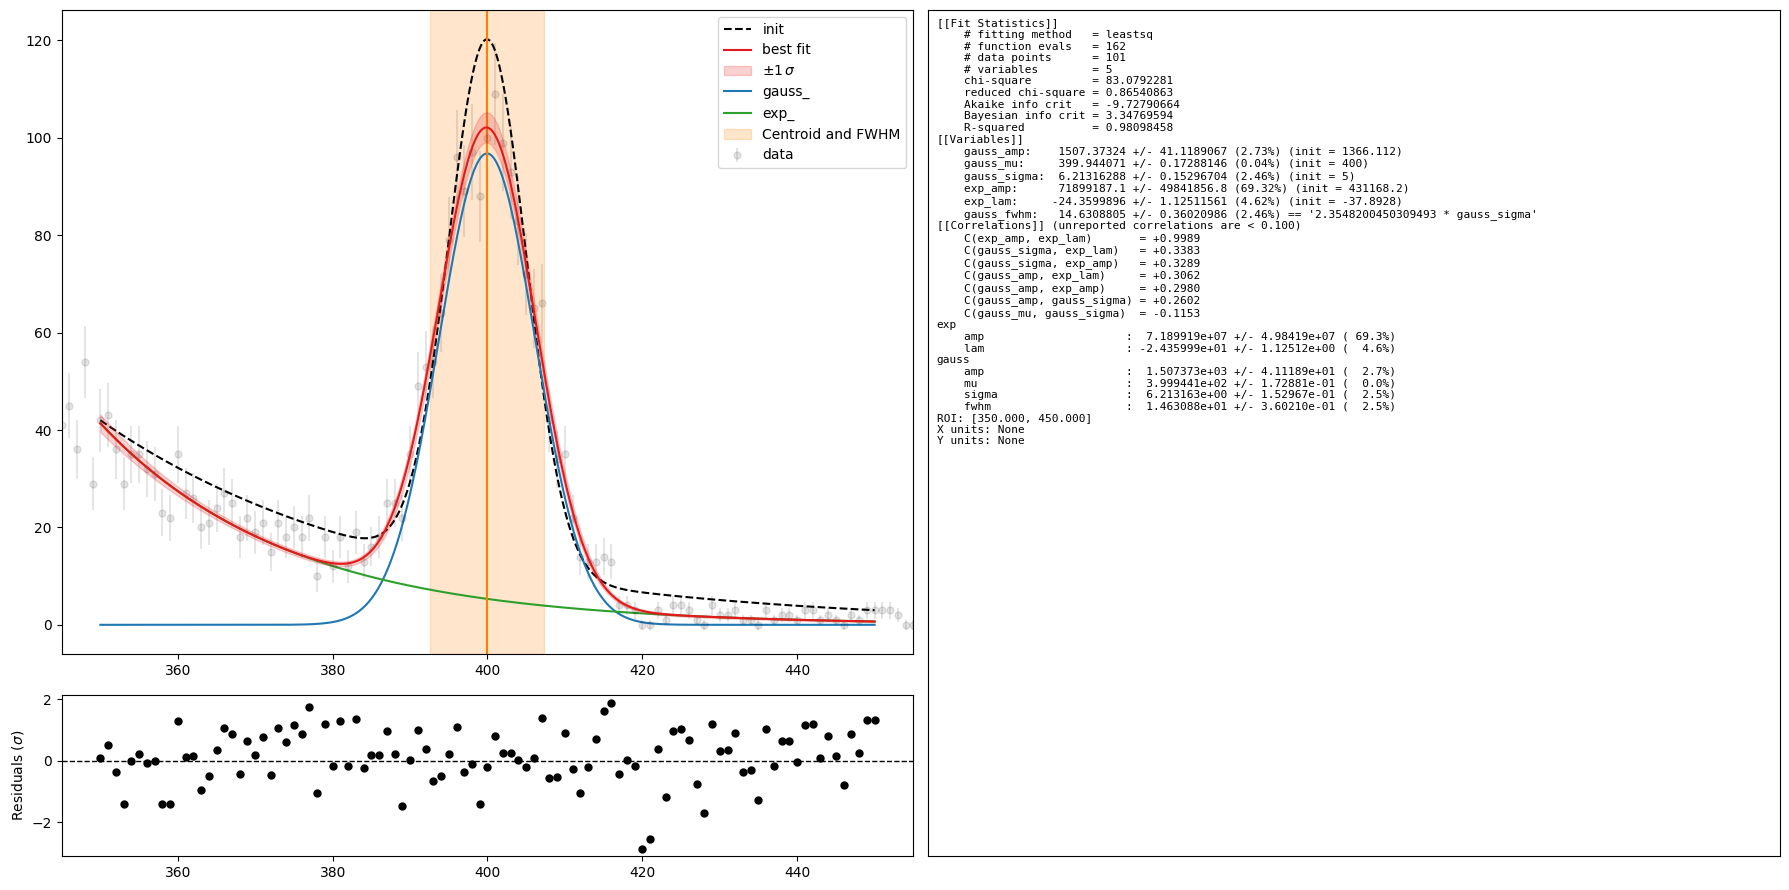

In [8]:
fitter.custom_plot(residual_type="sigma")
plt.tight_layout()
plt.show()

The normalized residuals help show that the exponential model fits fairly well---nearly all residuals are within $\pm2\sigma$, and there is no obvious trend.

We can also use the `iminuit` package to perform Poisson-loss fitting and also get uncertainties, a feature `lmfit` currently does not support.

In [9]:
fitter.fit(backend="minuit-pml")

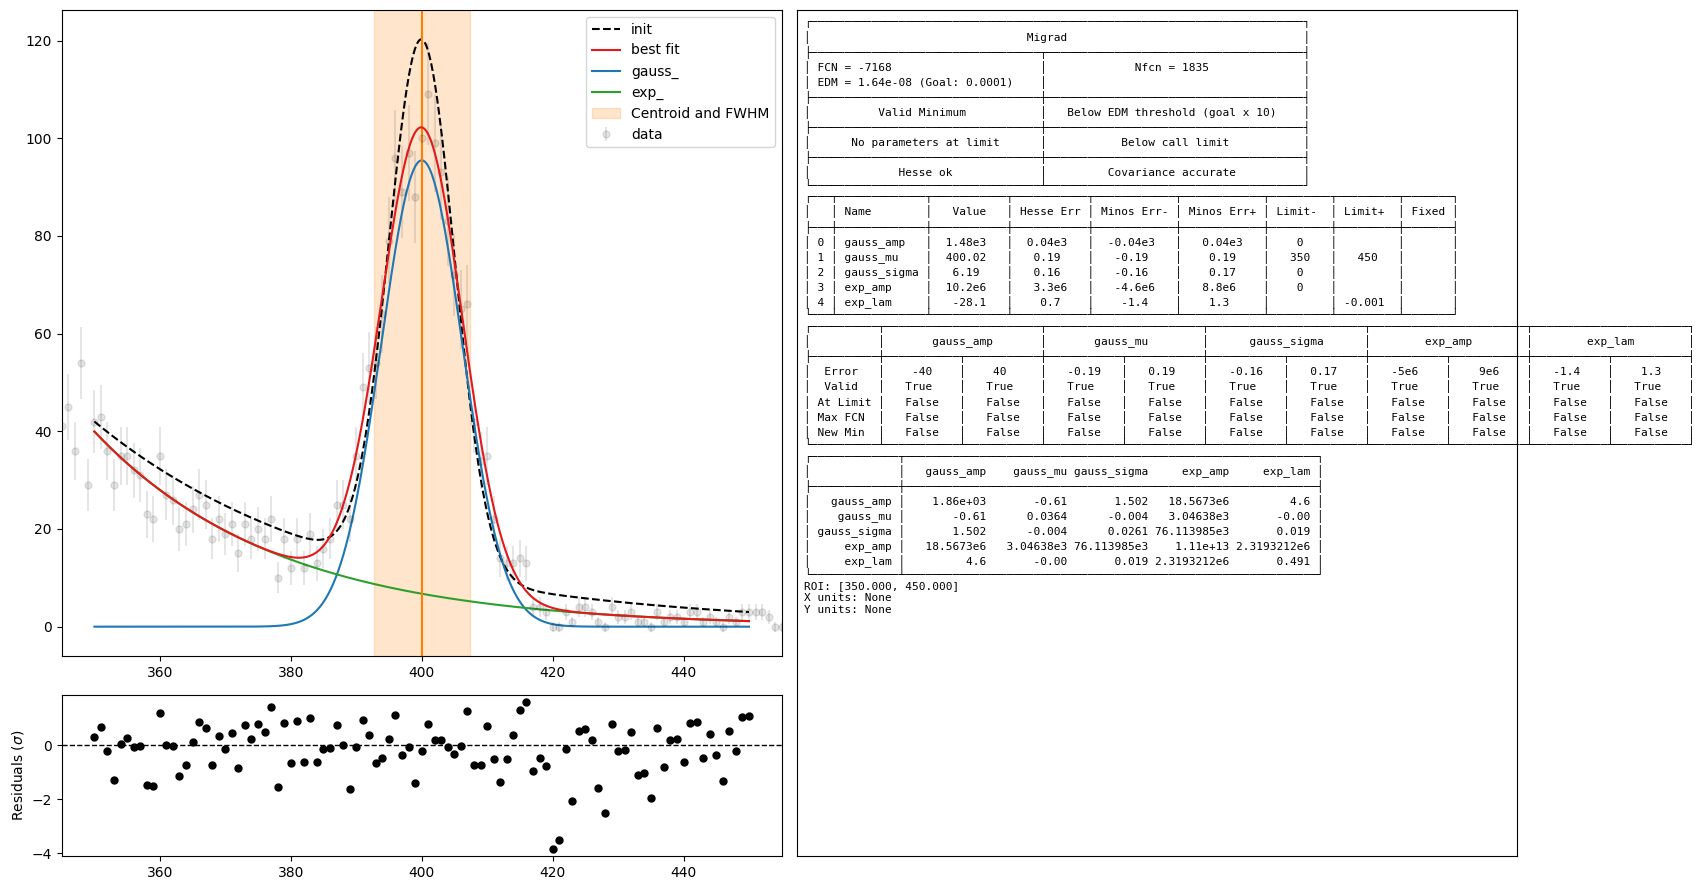

In [10]:
fitter.custom_plot(residual_type="sigma")
plt.tight_layout()
plt.show()

A better way to look at the `minuit` stats is with `fitter.result`. We can see that the fit parameters are valid, as are the error estimates.

In [11]:
fitter.result

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7168                      │             Nfcn = 1835              │
│ EDM = 1.64e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ gauss_amp   │  1.48e3   │  0.04e3   │  -0.04e3   │   0.04e3   │    0    │         │       │
│ 1 │ gauss_mu    │  400.02   │   0.19    │   -0.19    │    0.19    │   350   │   450   │       │
│ 2 │ gauss_sigma │   6.19    │   0.16    │   -0.16    │    0.17    │    0    │         │       │
│ 3 │ exp_amp     │  10.2e6   │   3.3e6   │   -4.6e6   │   8.8e6    │    0    │         │       │
│ 4 │ exp_lam     │   -28.1   │    0.7    │    -1.4    │    1.3     │         │ -0.001  │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │       gauss_amp       │       gauss_mu        │      gauss_sigma      │        exp_amp        │        exp_lam        │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -40    │    40     │   -0.19   │   0.19    │   -0.16   │   0.17    │   -5e6    │    9e6    │   -1.4    │    1.3    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌─────────────┬─────────────────────────────────────────────────────────────┐
│             │   gauss_amp    gauss_mu gauss_sigma     exp_amp     exp_lam │
├─────────────┼─────────────────────────────────────────────────────────────┤
│   gauss_amp │    1.86e+03       -0.61       1.502   18.5673e6         4.6 │
│    gauss_mu │       -0.61      0.0364      -0.004   3.04638e3       -0.00 │
│ gauss_sigma │       1.502      -0.004      0.0261 76.113985e3       0.019 │
│     exp_amp │   18.5673e6   3.04638e3 76.113985e3    1.11e+13 2.3193212e6 │
│     exp_lam │         4.6       -0.00       0.019 2.3193212e6       0.491 │
└─────────────┴─────────────────────────────────────────────────────────────┘

# Multiple gaussian fit

First we define a becquerel model with multiple gaussians and then we use that one and a set of parameters to create some synthetic data. Note that we can also mix and match custom `becquerel` and built-in `lmfit` models, but that their parameter names and meanings might differ.

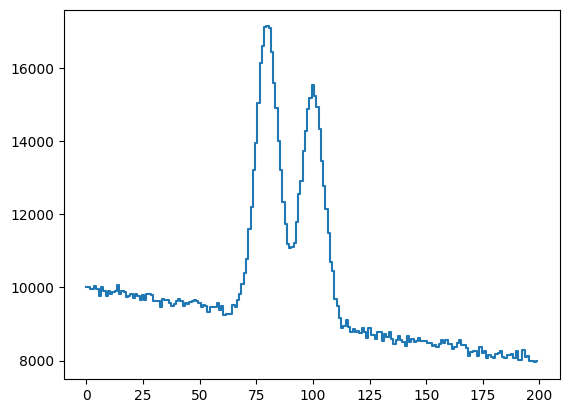

In [12]:
model = (
    bq.fitting.GaussModel(prefix="gauss0_")
    + bq.fitting.GaussModel(prefix="gauss1_")
    + lmfit.models.LinearModel(prefix="line_")
)

params = {
    "gauss0_amp": 1e5,
    "gauss0_mu": 80.0,
    "gauss0_sigma": 5.0,
    "gauss1_amp": 0.8e5,
    "gauss1_mu": 100.0,
    "gauss1_sigma": 5.0,
    "line_slope": -10.0,
    "line_intercept": 1e4,
}

x_data = np.arange(0, 200)
y_data = np.random.poisson(model.eval(x=x_data, **params))

plt.figure()
plt.step(x_data, y_data, where="mid")
plt.show()

Now we initialize the fitter with the model and define some initial guesses for the centroid.

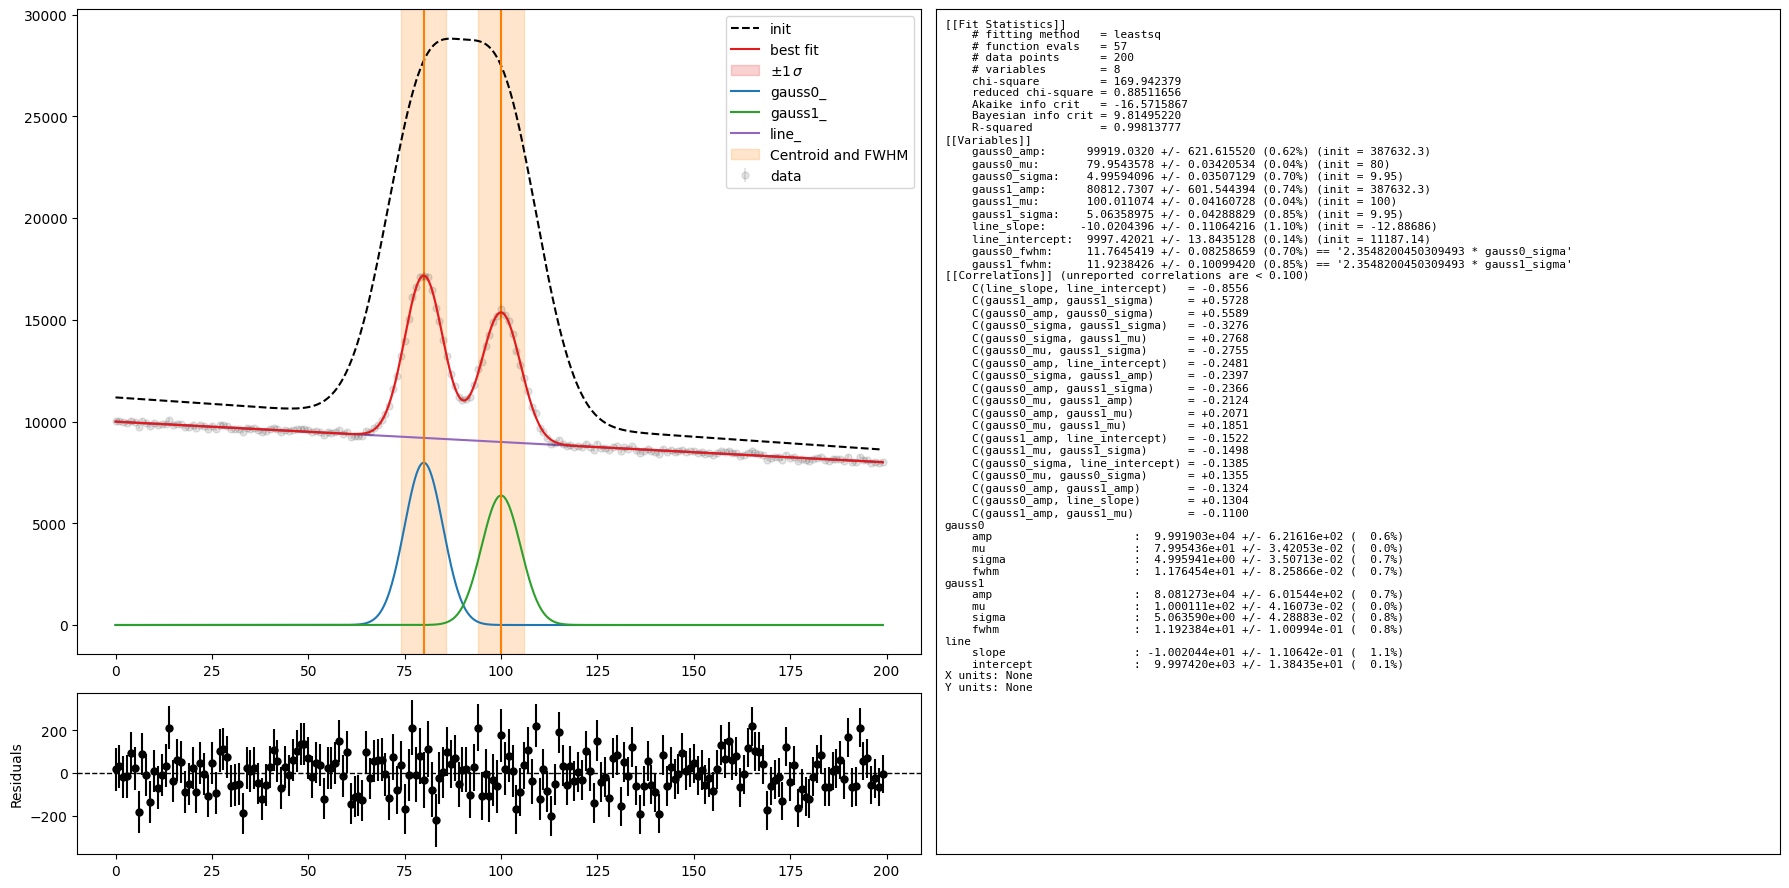

In [13]:
fitter = bq.Fitter(model, x=x_data, y=y_data, y_unc=np.sqrt(y_data))
fitter.params["gauss0_mu"].set(value=80.0)
fitter.params["gauss1_mu"].set(value=100.0)
fitter.fit()
fitter.custom_plot()
plt.tight_layout()
plt.show()

We can compute the areas (and uncertainties) under the entire fit:

In [14]:
print(fitter.calc_area_and_unc())

(1.9808+/-0.0013)e+06


or under individual components by name:

In [15]:
print(fitter.calc_area_and_unc("gauss0"))

(9.99+/-0.06)e+04


or via the list of model components itself:

In [16]:
print(fitter.model.components)
print(fitter.calc_area_and_unc(fitter.model.components[1]))

[Model(gauss, prefix='gauss0_'), Model(gauss, prefix='gauss1_'), Model(linear, prefix='line_')]
(8.08+/-0.06)e+04


and we can also restrict the range of `x` over which the areas are computed:

In [17]:
print(fitter.calc_area_and_unc("line"))
print(fitter.calc_area_and_unc("line", x=fitter.x[50:150]))

(1.8001+/-0.0014)e+06
(9.000+/-0.007)e+05


# Masked fitting

We can also pass a generic boolean mask (of the same length of `x`) to use for fitting. This can be useful for fitting only the background without the peak.

In [18]:
mask = (x_data < 25) | (x_data > 175)

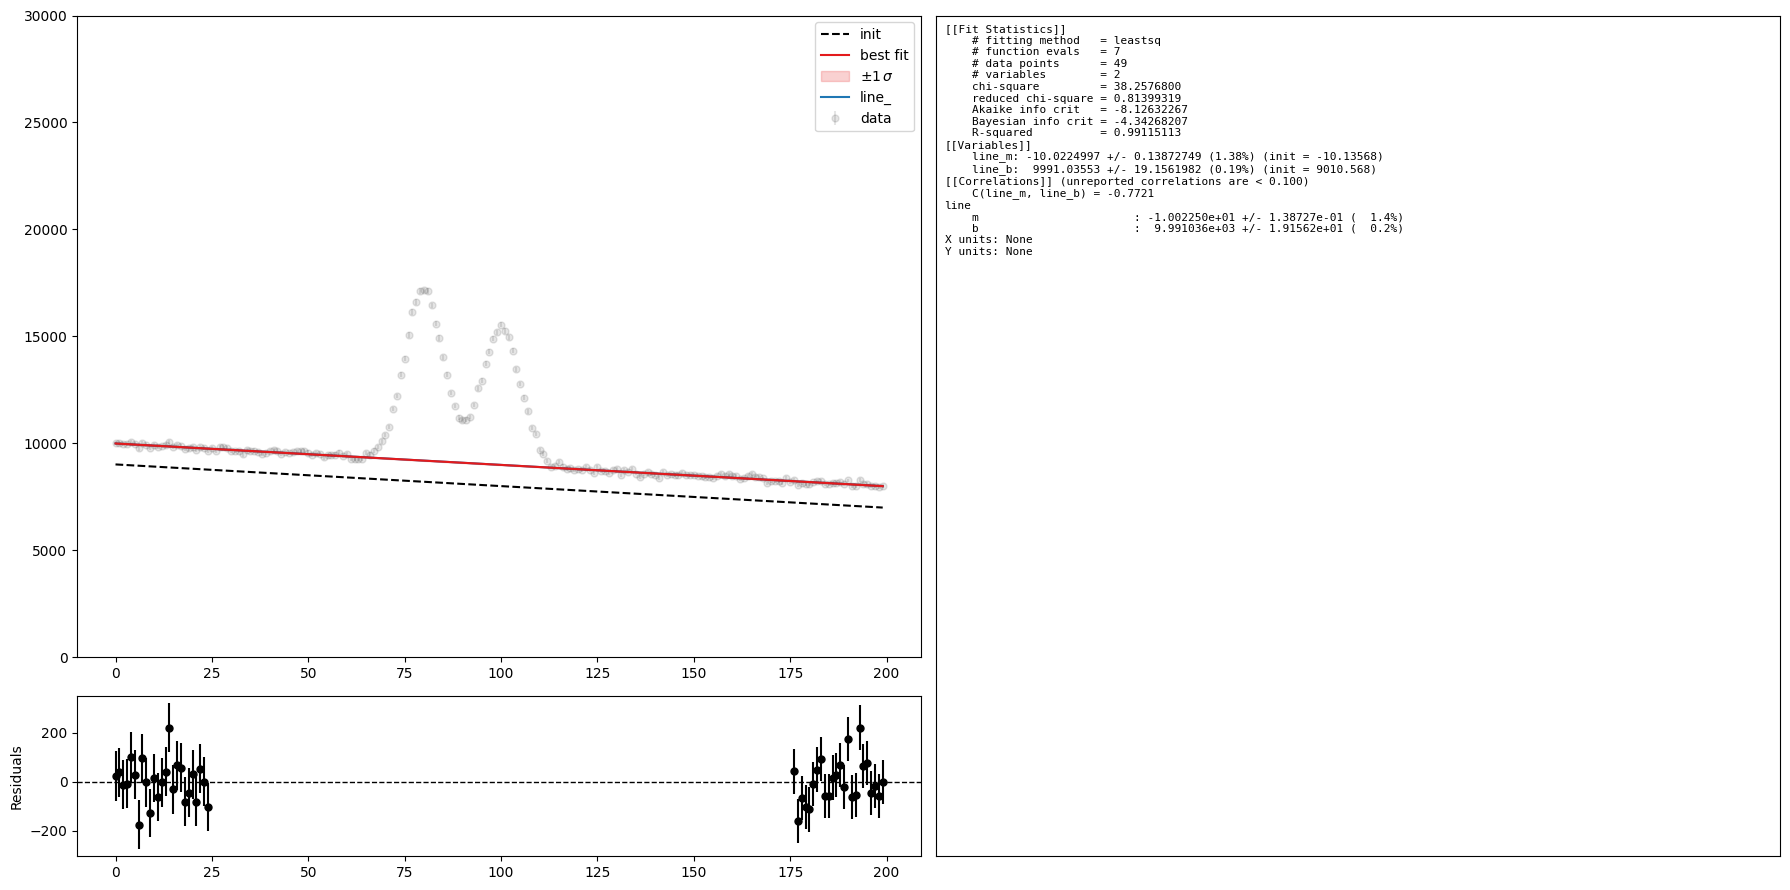

In [19]:
fitter = bq.Fitter(["line"], x=x_data, y=y_data, y_unc=np.sqrt(y_data), mask=mask)
fitter.fit()
fig = fitter.custom_plot()
fig.axes[0].set_ylim(0, 30000)
plt.tight_layout()
plt.show()

# Gauss + double exponential fit

Here's an example of fitting with the Gauss + double exponential tail (e.g. CZT detector)

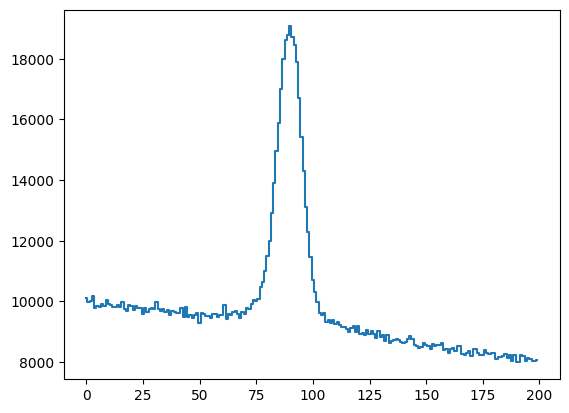

In [20]:
# Gauss + double exp + linear background
model = bq.fitting.GaussDblExpModel(prefix="gde_") + bq.fitting.LineModel(
    prefix="line_"
)

params = {
    "gde_amp": 1e4,
    "gde_mu": 90.0,
    "gde_sigma": 5.0,
    "gde_ltail_ratio": 0.3,
    "gde_ltail_slope": 0.1,
    "gde_ltail_cutoff": 1.0,
    "gde_rtail_ratio": 0.1,
    "gde_rtail_slope": -0.05,
    "gde_rtail_cutoff": 1.0,
    "line_m": -10.0,
    "line_b": 1e4,
}

# Make some synthetic data
x_data = np.arange(0, 200)
y_data = np.random.poisson(model.eval(x=x_data, **params))

plt.figure()
plt.step(x_data, y_data, where="mid")
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 111
    # data points      = 200
    # variables        = 11
    chi-square         = 176.060283
    reduced chi-square = 0.93153589
    Akaike info crit   = -3.49818242
    Bayesian info crit = 32.7833086
    R-squared          = 0.99823539
[[Variables]]
    gde_amp:           9854.01915 +/- 83.7999905 (0.85%) (init = 10000)
    gde_mu:            90.4677782 +/- 0.12216643 (0.14%) (init = 90)
    gde_sigma:         4.80651169 +/- 0.11128033 (2.32%) (init = 5)
    gde_ltail_ratio:   0.48884720 +/- 0.12673539 (25.93%) (init = 0.3)
    gde_ltail_slope:   0.12201012 +/- 0.01370976 (11.24%) (init = 0.1)
    gde_ltail_cutoff:  1.78697734 +/- 0.32264601 (18.06%) (init = 1)
    gde_rtail_ratio:   0.10656359 +/- 0.03684545 (34.58%) (init = 0.1)
    gde_rtail_slope:  -0.05429657 +/- 0.01284264 (23.65%) (init = -0.05)
    gde_rtail_cutoff:  0.43059434 +/- 0.29387889 (68.25%) (init = 1)
    line_m:           -9.89346778 

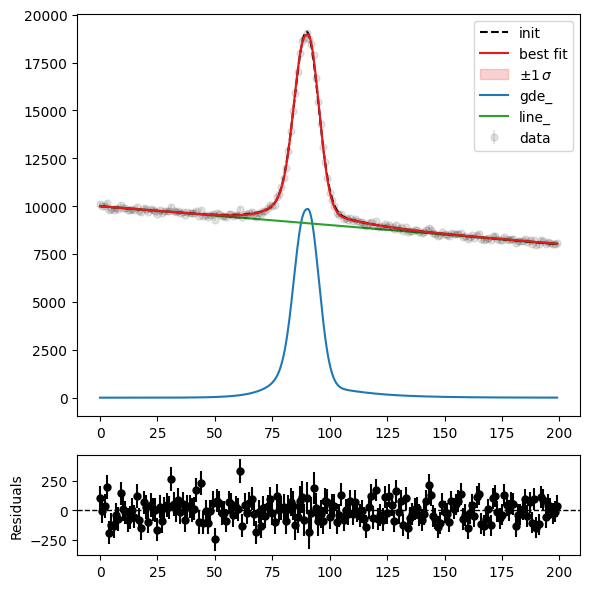

In [21]:
# Fit the synthetic data with the model
fitter = bq.Fitter(model, x=x_data, y=y_data, y_unc=np.sqrt(y_data))
fitter.params["gde_amp"].set(value=1e4)
fitter.params["gde_mu"].set(value=90.0)
fitter.params["gde_sigma"].set(value=5.0)
fitter.params["gde_ltail_ratio"].set(value=0.3)
fitter.params["gde_ltail_slope"].set(value=0.1)
fitter.params["gde_rtail_ratio"].set(value=0.1)
fitter.params["gde_rtail_slope"].set(value=-0.05)

# These tend to not contribute much, and can give the fitter a hard time
# You'll notice that the fit result finds ltail_cutoff = 1.78, and
# rtail_cutoff = 0.43, even though we used 1.0/1.0 to generate the data
# You may want to only fit these once, maybe coarsely, then fix them
fitter.params["gde_ltail_cutoff"].set(value=1.0)
fitter.params["gde_rtail_cutoff"].set(value=1.0)

fitter.params["line_m"].set(value=-10.0)
fitter.params["line_b"].set(value=1e4)
fitter.fit()
print(fitter.result)
print(lmfit.fit_report(fitter.result))

fitter.custom_plot(figsize=(6, 6), enable_fit_panel=False)
plt.tight_layout()
plt.show()